In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score

# time series data so do not use this splitter
from sklearn.model_selection import train_test_split

# if you do not want to use the manual one i showed you, you can use the following
from sklearn.model_selection import TimeSeriesSplit

# visualization libraries
from matplotlib import pyplot as plt
import matplotlib as mpl

/home/jalfonso/anaconda3/envs/PythonTime/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jalfonso/anaconda3/envs/PythonTime/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [ ]:
# importing date time functionalities
from datetime import datetime

In [34]:
# good way of preloading the dtypes as opposed to doing these laterere
median=pd.read_csv('medianSalesPrice.csv', dtype={"Bedrooms": int, "RegionName": "string"})
median=median.drop(columns=['RegionID','SizeRank','RegionType','StateName','State','Metro','City','CountyName'])
median=median.rename(columns={'RegionName':'Zipcode'})
median.head()

/home/jalfonso/anaconda3/envs/PythonTime/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Bedrooms,Zipcode,1/31/2015,2/28/2015,3/31/2015,4/30/2015,5/31/2015,6/30/2015,7/31/2015,8/31/2015,...,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021
0,1,10025,687255.0,692013.0,692222.0,691676.0,690212.0,691754.0,693115.0,695782.0,...,689319.0,688401.0,687989.0,686916.0,685278.0,682705.0,681110.0,680490.0,681329.0,681740.0
1,1,60657,205053.0,204925.0,205317.0,206342.0,206843.0,205887.0,205218.0,205337.0,...,217151.0,217353.0,217807.0,218778.0,220062.0,221396.0,222713.0,224034.0,225383.0,226155.0
2,1,10023,832919.0,834728.0,835364.0,840480.0,840354.0,844932.0,848041.0,851860.0,...,764479.0,762927.0,763024.0,762572.0,762335.0,762696.0,764745.0,766037.0,768289.0,769852.0
3,1,60614,233676.0,233681.0,234129.0,235117.0,236302.0,236381.0,236871.0,237395.0,...,246589.0,246965.0,247455.0,247958.0,248226.0,248181.0,248364.0,249036.0,250130.0,250644.0
4,1,77449,104257.0,105348.0,105860.0,107274.0,108457.0,109481.0,109150.0,109544.0,...,137762.0,138753.0,139456.0,140111.0,140617.0,142016.0,143976.0,146953.0,149562.0,151943.0


# Selecting Zip codes
- assumption: we care for zipcode level data and are agnostic about the city
- we have another dimension with bedrooms which needs to be taken care of in the time series side. because the bedroom value does not happen in silo, and it is not an either 1,2,3,4,5 for each day we can assume that we need to silo the data for each bedroom as well

In [21]:
zip_codes_study=[]
z_code='10'
while z_code!='':
    z_code=input('Enter zipcode: ')
    if z_code =='':
        continue
    zip_codes_study.append(z_code)
    
zip_codes_study

Enter zipcode: 33178
Enter zipcode: 33131
Enter zipcode: 


['33178', '33131']

In [9]:
datetime.fromordinal('4/30/2020')

TypeError: an integer is required (got type str)

In [8]:
datetime.fromisoformat('2021-02-01')

datetime.datetime(2021, 2, 1, 0, 0)

In [29]:
bedrooms= median['Bedrooms'].unique() # get the available choices in our dataset

In [43]:
Zipcode='33178'
bedrooms=2

median.query("Bedrooms == @bedrooms & Zipcode==@Zipcode")

,Bedrooms,Zipcode,1/31/2015,2/28/2015,3/31/2015,4/30/2015,5/31/2015,6/30/2015,7/31/2015,8/31/2015,...,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021
19200,2,33178,231300.0,231248.0,231027.0,231400.0,232539.0,233295.0,234073.0,234704.0,...,249556.0,249560.0,249134.0,249153.0,249559.0,250467.0,251510.0,252071.0,253238.0,254715.0


In [48]:
median.query("Bedrooms == 1 & Zipcode=='33178'").T[2:]

,623
1/31/2015,219321
2/28/2015,219223
3/31/2015,219191
4/30/2015,218721
5/31/2015,217711
...,...
9/30/2020,208198
10/31/2020,209419
11/30/2020,209805
12/31/2020,210270


In [64]:
house_data_matrix={}
for bedroom in range(1,6):
    for zip_code in zip_codes_study:
        house_data_matrix[zip_code+'_'+str(bedroom)]=median.query("Bedrooms == @bedrooms & Zipcode==@Zipcode").T[2:].copy()
        house_data_matrix[zip_code+'_'+str(bedroom)].index=pd.to_datetime(house_data_matrix[zip_code+'_'+str(bedroom)].index)
        old_col=house_data_matrix[zip_code+'_'+str(bedroom)].columns[0]
        house_data_matrix[zip_code+'_'+str(bedroom)]=house_data_matrix[zip_code+'_'+str(bedroom)].rename(columns={
            old_col:zip_code+'_'+str(bedroom)
        })

In [65]:
house_data_matrix.keys()

dict_keys(['33178_1', '33131_1', '33178_2', '33131_2', '33178_3', '33131_3', '33178_4', '33131_4', '33178_5', '33131_5'])

In [73]:
house_data_matrix['33131_1'].describe()

,33131_1
count,73.0
unique,73.0
top,247678.0
freq,1.0


In [74]:
house_data_matrix['33178_1'].describe()

,33178_1
count,73.0
unique,73.0
top,247678.0
freq,1.0


In [77]:
house_data_matrix['33178_1'].head()

,33178_1
2015-01-31,231300
2015-02-28,231248
2015-03-31,231027
2015-04-30,231400
2015-05-31,232539


In [79]:
house_data_matrix['33178_1'].iloc[0:-10:]

,33178_1
2015-01-31,231300
2015-02-28,231248
2015-03-31,231027
2015-04-30,231400
2015-05-31,232539
...,...
2019-11-30,251412
2019-12-31,250856
2020-01-31,250072
2020-02-29,249797


# Using a Time Series Model

In [100]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

In [88]:
np.asarray(train['33178_1'])

array([231300.0, 231248.0, 231027.0, 231400.0, 232539.0, 233295.0,
       234073.0, 234704.0, 235536.0, 235838.0, 235907.0, 236571.0,
       238428.0, 240260.0, 242119.0, 242969.0, 243468.0, 244505.0,
       246171.0, 247160.0, 247630.0, 247493.0, 247678.0, 247470.0,
       247310.0, 247287.0, 246769.0, 246567.0, 246759.0, 246672.0,
       245961.0, 245757.0, 245699.0, 246489.0, 246026.0, 246185.0,
       246049.0, 246708.0, 247412.0, 248272.0, 248505.0, 248574.0,
       248598.0, 248880.0, 249298.0, 249367.0, 250890.0, 251579.0,
       252491.0, 251765.0, 251513.0, 251358.0, 251397.0, 252295.0,
       252919.0, 252916.0, 252315.0, 251740.0, 251412.0, 250856.0,
       250072.0], dtype=object)

In [106]:
train.values.ravel()

array([231300.0, 231248.0, 231027.0, 231400.0, 232539.0, 233295.0,
       234073.0, 234704.0, 235536.0, 235838.0, 235907.0, 236571.0,
       238428.0, 240260.0, 242119.0, 242969.0, 243468.0, 244505.0,
       246171.0, 247160.0, 247630.0, 247493.0, 247678.0, 247470.0,
       247310.0, 247287.0, 246769.0, 246567.0, 246759.0, 246672.0,
       245961.0, 245757.0, 245699.0, 246489.0, 246026.0, 246185.0,
       246049.0, 246708.0, 247412.0, 248272.0, 248505.0, 248574.0,
       248598.0, 248880.0, 249298.0, 249367.0, 250890.0, 251579.0,
       252491.0, 251765.0, 251513.0, 251358.0, 251397.0, 252295.0,
       252919.0, 252916.0, 252315.0, 251740.0, 251412.0, 250856.0,
       250072.0], dtype=object)

In [108]:
pd.Series(train.values.ravel(),train.index)

2015-01-31    231300
2015-02-28    231248
2015-03-31    231027
2015-04-30    231400
2015-05-31    232539
               ...  
2019-09-30    252315
2019-10-31    251740
2019-11-30    251412
2019-12-31    250856
2020-01-31    250072
Length: 61, dtype: object

In [221]:
num_months=12 # you can change this is you want for your model

zip_bdr='33178_1'


train = house_data_matrix[zip_bdr].iloc[0:-num_months, :]  # if you wish to predict another series, then chg
test = house_data_matrix[zip_bdr].iloc[-num_months:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

train_eval=train.copy()
pred = test.copy() # this way do not need to create an eval dataframe, just populate

# model = SimpleExpSmoothing(np.asarray(train['data']))
# model._index = pd.to_datetime(train.index)

exp_model = ExponentialSmoothing(np.asarray(train[zip_bdr]), trend='mul', seasonal=None)
# model2 = ExponentialSmoothing(np.asarray(train['data']), trend='mul', seasonal=None, damped=True)
# model._index = pd.to_datetime(train.index)
exp_model_fit = exp_model.fit()

holt_model_fit = Holt(np.asarray(train[zip_bdr]), exponential=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)


/home/jalfonso/anaconda3/envs/PythonTime/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/home/jalfonso/anaconda3/envs/PythonTime/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/jalfonso/anaconda3/envs/PythonTime/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [161]:
exp_model_fit.summary()

Dep. Variable:,endog,No. Observations:,61
Model:,ExponentialSmoothing,SSE,18653064.198
Optimized:,True,AIC,778.469
Trend:,Multiplicative,BIC,786.913
Seasonal:,None,AICC,780.025
Seasonal Periods:,None,Date:,"Sun, 07 Mar 2021"
Box-Cox:,False,Time:,13:24:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.6870238,beta,True


In [222]:
holt_model_fit.forecast(num_months),exp_model_fit.forecast(num_months)

(array([249926.59557764, 249636.83946933, 249347.41929405, 249058.33466236,
        248769.58518522, 248481.17047408, 248193.09014081, 247905.34379775,
        247617.93105768, 247330.85153385, 247044.10483991, 246757.69059002]),
 array([249380.86865243, 248690.23104922, 248001.50610395, 247314.68851969,
        246629.77301418, 245946.75431978, 245265.62718345, 244586.38636669,
        243909.02664551, 243233.54281038, 242559.92966622, 241888.18203231]))

In [223]:
holt_model_fit.summary()

Dep. Variable:,endog,No. Observations:,61
Model:,Holt,SSE,27420087.637
Optimized:,False,AIC,801.971
Trend:,Multiplicative,BIC,810.414
Seasonal:,None,AICC,803.526
Seasonal Periods:,None,Date:,"Sun, 07 Mar 2021"
Box-Cox:,False,Time:,14:22:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8000000,alpha,False
smoothing_trend,0.2000000,beta,False


In [224]:
train_eval['exp_model']=exp_model_fit.fittedvalues
train_eval['holt_model']=holt_model_fit.fittedvalues

In [225]:
pred['exp_model']=exp_model_fit.forecast(num_months)
pred['holt_model']=holt_model_fit.forecast(num_months)

In [226]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [227]:
plt.style.use('seaborn-notebook')

Text(0, 0.5, 'Home Value: 33178_1')

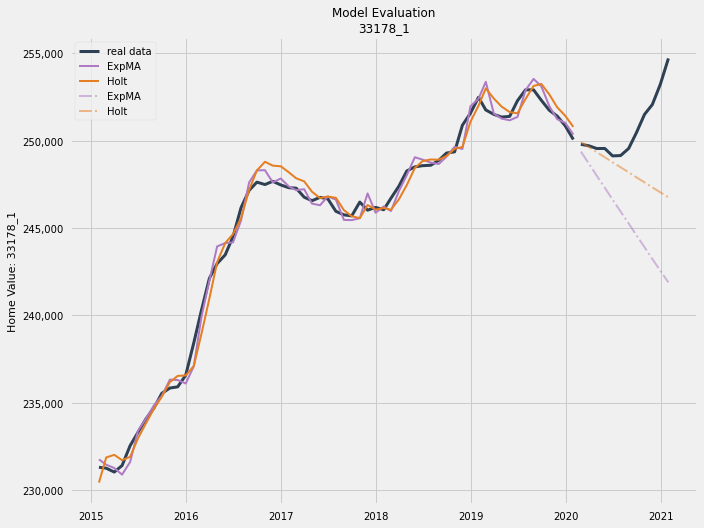

In [228]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.plot(train_eval.index,train_eval[zip_bdr],label='real data',color='#2e4053',linewidth=3)
ax.plot(train_eval.index,train_eval['exp_model'],label='ExpMA',color='#af7ac5',linewidth=2)
ax.plot(train_eval.index,train_eval['holt_model'],label='Holt',color='#e67e22',linewidth=2)
plt.title(f'Model Evaluation\n{train.columns[0]}')
#plot the predictions
ax.plot(pred.index,pred[zip_bdr],color='#2e4053',linewidth=3)
ax.plot(pred.index,pred.exp_model,label='ExpMA',color='#af7ac5',linewidth=2,linestyle='-.',alpha=0.5)
ax.plot(pred.index,pred.holt_model,label='Holt',color='#e67e22',linewidth=2,linestyle='-.',alpha=0.5)
plt.legend(loc='best')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel(f'Home Value: {train.columns[0]}')

# Question for you
- why would Exponential moving average be worse for your model?
- where would exponential make more sense for you?

In [218]:
# holt_model_fit.params